In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## CLASS Boltzmann code ##

There are two "commonly used" codes which evolve the linearized perturbation equations for cosmology.  These are highly useful tools for working in the CMB or large-scale structure, so here I introduce one of them: the [Cosmic Linear Anisotropy Solving System](http://class-code.net/).  This code is very well documented and maintained, and a public version is avaialble [at this GitHub repo](https://github.com/lesgourg/class_public), making it easy to keep up to date (or to contribute!).

If you clone the repository, e.g. with
`git clone https://github.com/lesgourg/class_public class`
then you can just go into the class directory and "make" the code.  I've never had a problem with this on any machine that a few edits to the Makefile didn't fix.  If you want to install the Python interface just go into the Python directory and use `python setup.py install`.  On the datahub you can install as root so you don't need the `--user`, otherwise you can use your own system.  There is also a `Conda` version if you use an Anaconda python distribution.

Though we won't use it here, the CLASS code also interfaces with the [MontePython](https://github.com/brinckmann/montepython_public) Markov Chain Monte Carlo and parameter extraction software.  Unfortunately last I checked this code was stuck on Python2, so you won't be able to use it on a modern platform (e.g. `datahub.berkeley.edu`)

In [2]:
# Import the Class class.
from classy import Class

In [3]:
# Here's the basic workflow from within Python:
#
# Define the cosmology (what is not specified will be set to CLASS default parameters).
# We'll use the "Planck 2018 cosmology" (plus BAO), defined in the right-hand column
# of Table 6 in https://arxiv.org/pdf/1807.06205.pdf
# We'll ask for CMB temperature anisotropy spectra, lensed spectra and matter P(k):
params = {
    'output': 'tCl lCl mPk',
    'l_max_scalars': 2000,
    'P_k_max_h/Mpc': 20.,
    'lensing': 'yes',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    'h': 0.6770,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}  
# Could have specified z_reio instead of tau_reio.
#
# Create an instance of the CLASS wrapper
cosmo = Class()
#
# Set the parameters to the cosmological code
cosmo.set(params)
#
# Run the whole code. How long this takes depends upon how
# many quantities you ask for.  For instance, without any
# 'output' requested, CLASS will only compute background quantities,
# thus running almost instantaneously.  In our case it should
# take a few seconds to run.
cosmo.compute()

In [4]:
# The code gives us a whole lot of background cosmology information.
# This is similar in spirit to the astropy routines.
# Let's get the luminosity distance to z=1:
print("dL={:.2f}".format(cosmo.luminosity_distance(1.0)))
# Or the "angular" distance:
print("dA={:.2f}".format(cosmo.angular_distance(1.0)))

dL=6789.44
dA=1697.36


In [5]:
# And it has lots of other things it can tell you...
cosmo.get_current_derived_parameters(['H0','Omega_m','Omega_Lambda',\
                                      'age','conformal_age','Neff',\
                                      'z_reio','100*theta_s','rs_rec','rs_d'])

{'H0': 67.7,
 'Omega_m': 0.31052192069532447,
 'Omega_Lambda': 0.6893992131586856,
 'age': 13.785633583386252,
 'conformal_age': 14166.937083683666,
 'Neff': 3.045998221453421,
 'z_reio': 7.9044952392578125,
 '100*theta_s': 1.0418265956532584,
 'rs_rec': 144.66691134886878,
 'rs_d': 147.21414455012248}

In [6]:
# We can also do things like the growth factor and growth rate.
for zz in np.arange(0.0,2.51,0.5):
    print("At z={:4.1f}, D(z)={:8.4f}, f(z)={:8.4f}".\
          format(zz,cosmo.scale_independent_growth_factor(zz),\
                 cosmo.scale_independent_growth_factor_f(zz)))

At z= 0.0, D(z)=  1.0000, f(z)=  0.5214
At z= 0.5, D(z)=  0.7707, f(z)=  0.7554
At z= 1.0, D(z)=  0.6091, f(z)=  0.8719
At z= 1.5, D(z)=  0.4981, f(z)=  0.9271
At z= 2.0, D(z)=  0.4195, f(z)=  0.9547
At z= 2.5, D(z)=  0.3616, f(z)=  0.9696


dict_keys(['z', 'conf. time [Mpc]', 'x_e', "kappa' [Mpc^-1]", 'exp(-kappa)', 'g [Mpc^-1]', 'Tb [K]', 'c_b^2', 'tau_d'])


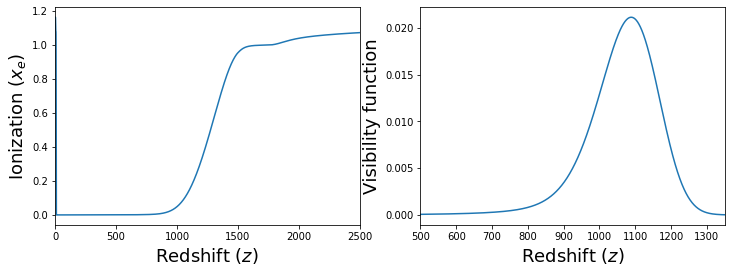

In [7]:
# We can also get lots of "thermodynamics" parameters.  For example,
# here's a plot of the ionization fraction (x_e) versus redshift
# and the visibility function (probability a photon scatters per
# unit length) vs. redshift.
thermo = cosmo.get_thermodynamics()
#
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(thermo['z'],thermo['x_e'])
ax[0].set_xlim([0.0,2500.0])
ax[0].set_xlabel(r'Redshift ($z$)',fontsize=18)
ax[0].set_ylabel(r'Ionization ($x_e$)',fontsize=18)
#
ax[1].plot(thermo['z'],thermo['g [Mpc^-1]'])
ax[1].set_xlim([500.0,1350.0])
ax[1].set_xlabel(r'Redshift ($z$)',fontsize=18)
ax[1].set_ylabel(r'Visibility function',fontsize=18)
# You can also do it vs. conformal time, or plot the differential
# optical depth etc.
print(thermo.keys())

In [8]:
# Access the lensed cl until l=2000
cls = cosmo.lensed_cl(2000)

Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/(2\\pi)$')

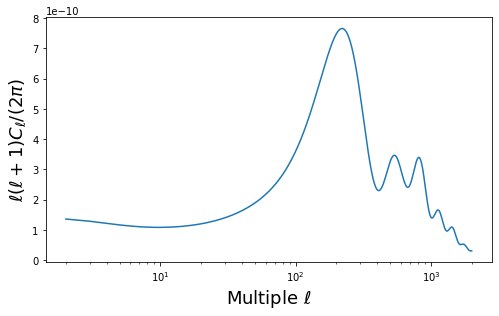

In [9]:
# Plot the temperature C_l's just to show we've got this working.
fig,ax = plt.subplots(1,1,figsize=(8,4.5))
ell = cls['ell'][2:]  # Start at the quadrupole.
fac = ell*(ell+1)/(2*np.pi)
ax.plot(ell,fac*cls['tt'][2:])
ax.set_xscale('log')
ax.set_xlabel(r'Multiple $\ell$',fontsize=18)
ax.set_ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$',fontsize=18)

Text(0.5, 0, 'Multiple $\\ell$')

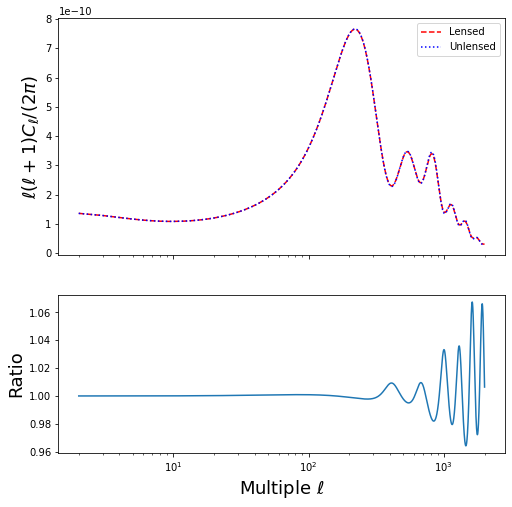

In [10]:
# We can compare the spectra with and without lensing:
lcls = cosmo.lensed_cl(2000)
ucls = cosmo.raw_cl(2000)
#
fig,ax = plt.subplots(2,1,figsize=(8,8),sharex=True,gridspec_kw={'height_ratios':[3,2]})
ell = lcls['ell'][2:]  # Start at the quadrupole.
fac = ell*(ell+1)/(2*np.pi)
ax[0].plot(ell,fac*lcls['tt'][2:],'r--',label='Lensed')
ax[0].plot(ell,fac*ucls['tt'][2:],'b:',label='Unlensed')
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$',fontsize=18)
#
ax[1].plot(ell,lcls['tt'][2:]/ucls['tt'][2:])
ax[1].set_ylabel(r'Ratio',fontsize=18)
ax[1].set_xlabel(r'Multiple $\ell$',fontsize=18)

## Varying parameters ##

The computation of "linear theory" quantities is no longer cutting edge research cosmology, but the flip side of this is that most people specializing in cosmology are expected to know how things like the matter power spectrum or CMB spectra change as the basic cosmological parameters are varied.  You can experiment with this easily now, and see whether you can understand why the curves move the way they do.

Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/(2\\pi)$')

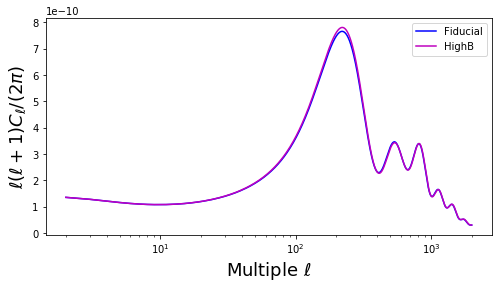

In [11]:
# Let's do a high-baryon example for comparison -- I'll increase omegab by 0.001 and
# decrease omegacdm by the same amount (to hold omegam fixed).
hib = Class()
hib.set({'output': 'tCl lCl mPk','l_max_scalars': 2000,'lensing': 'yes',\
         'A_s': np.exp(3.040)*1e-10,'n_s': 0.96824,'h': 0.6770,\
         'tau_reio': 0.0568,'omega_b': 0.023447,'omega_cdm': 0.11823,\
         'N_ur': 2.0328,'N_ncdm': 1,'m_ncdm': 0.06})
hib.compute()
#
cl1 = cosmo.lensed_cl(2000)
cl2 = hib.lensed_cl(2000)
#
fig,ax = plt.subplots(1,1,figsize=(8,4))
ell = cl1['ell'][2:]  # Start at the quadrupole.
fac = ell*(ell+1)/(2*np.pi)
ax.plot(ell,fac*cl1['tt'][2:],'b-',label='Fiducial')
ax.plot(ell,fac*cl2['tt'][2:],'m-',label='HighB')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel(r'Multiple $\ell$',fontsize=18)
ax.set_ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$',fontsize=18)

sigma8= 0.807


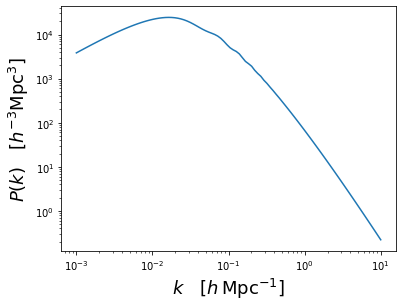

In [12]:
# Going back to our fiducial model we can also look at the matter power spectrum:
zz = 0.0
kk = np.logspace(-3.0,1.0,100)
pk = np.array( [cosmo.pk(k*params['h'],zz)*params['h']**3 for k in kk] )
#
fig,ax = plt.subplots(1,1,figsize=(6,4.5))
ax.plot(kk,pk)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$',fontsize=18)
ax.set_ylabel(r'$P(k)\quad [h^{-3}{\rm Mpc}^3]$',fontsize=18)
#
print("sigma8={:6.3f}".format(cosmo.sigma8()))

If you wanted to look at the power spectrum at $z\ne 0$ then you can specify the range of interest using the `z_pk` keyword, which takes a string as in
```
'z_pk': '0.0,10'
```
to ask for $0\le z\le 10$.

## Massive neutrinos ##

Now we can play with the effect of massive neutrinos on the matter power spectrum.

In [13]:
params = {'output': 'tCl lCl mPk',\
          'l_max_scalars': 2000,'P_k_max_h/Mpc': 25.,'lensing': 'yes',\
          'A_s': np.exp(3.040)*1e-10,'n_s': 0.96824,'h': 0.6770,\
          'tau_reio': 0.0568,'omega_b': 0.022447,'omega_cdm': 0.11923,\
          'N_ur': 2.0328,'N_ncdm': 1}
NH = Class()
NH.set(params)
NH.set({'m_ncdm': 0.06})
NH.compute()
# inverted hierarchy
IH = Class()
IH.set(params)
IH.set({'m_ncdm': 0.10})
IH.compute()

Text(0, 0.5, 'Ratio')

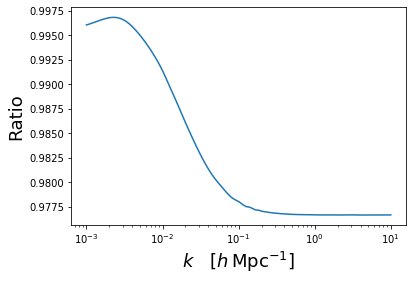

In [14]:
kk  = np.logspace(-3.0,1.0,100)
Pnh = np.array([NH.pk(k,0.0) for k in kk])
Pih = np.array([IH.pk(k,0.0) for k in kk])
#
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(kk,Pih/Pnh)
ax.set_xscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$',fontsize=18)
ax.set_ylabel(r'Ratio',fontsize=18)

The effect that neutrinos have on the matter power spectrum depends to some extent on what else you're holding fixed.  As one example, do we hold $\omega_c$ and $\omega_b$ fixed when we introduce $m_\nu$ or do we hold the low $z$ matter density ($\omega_m$, including the neutrinos) fixed?  These different choices affect the shape of the plateau.

In [19]:
# Set up a "standard" case with massless neutrinos.
params = {'output': 'mPk','P_k_max_h/Mpc': 25.,\
          'A_s': np.exp(3.040)*1e-10,'n_s': 0.96824,'h': 0.6770,\
          'tau_reio': 0.0568,'omega_b': 0.022447,'omega_cdm': 0.11923,\
          'N_ur': 3.0328}
Fid = Class()
Fid.set(params)
Fid.compute()
# Add massive neutrinos, holding omega_cdm fixed.
params = {'output': 'mPk','P_k_max_h/Mpc': 25.,\
          'A_s': np.exp(3.040)*1e-10,'n_s': 0.96824,'h': 0.6770,\
          'tau_reio': 0.0568,'omega_b': 0.022447,'omega_cdm': 0.11923,\
          'N_ur': 2.0328,'N_ncdm': 1, 'omega_ncdm': 0.005}
OC = Class()
OC.set(params)
OC.compute()
# Add massive neutrinos, holding omega_m fixed.
params = {'output': 'mPk','P_k_max_h/Mpc': 25.,\
          'A_s': np.exp(3.040)*1e-10,'n_s': 0.96824,'h': 0.6770,\
          'tau_reio': 0.0568,'omega_b': 0.022447,'omega_cdm': 0.11923-0.005,\
          'N_ur': 2.0328,'N_ncdm': 1, 'omega_ncdm': 0.005}
OM = Class()
OM.set(params)
OM.compute()

Text(0, 0.5, 'Ratio')

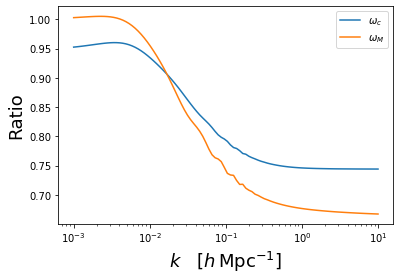

In [20]:
kk       = np.logspace(-3.0,1.0,100)
ratio_OC = np.array([OC.pk(k,0.0)/Fid.pk(k,0.0) for k in kk])
ratio_OM = np.array([OM.pk(k,0.0)/Fid.pk(k,0.0) for k in kk])
#
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(kk,ratio_OC,label=r'$\omega_c$')
ax.plot(kk,ratio_OM,label=r'$\omega_M$')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$',fontsize=18)
ax.set_ylabel(r'Ratio',fontsize=18)

## Tensor modes ##

Finally, let's look at how primordial tensor modes show up.

In [15]:
params = {'output': 'tCl, pCl, lCl', 'modes':'s,t',
    'l_max_scalars': 2000, 'l_max_tensors': 1000,
    'lensing': 'yes',
    'r': 0.01,
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824, 
    'h': 0.6770,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
T = Class()
T.set(params)
T.compute()
#
cl_tot = T.raw_cl(2000)
cl_lensed = T.lensed_cl(2000)

Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/(2\\pi)$')

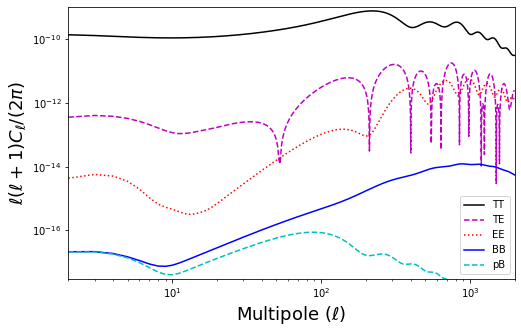

In [16]:
# Extract the lensed spectra, starting from the quadrupole:
ell = cl_lensed['ell'][2:]
ClTT= cl_lensed[ 'tt'][2:]
ClTE= cl_lensed[ 'te'][2:]
ClEE= cl_lensed[ 'ee'][2:]
ClBB= cl_lensed[ 'bb'][2:]
fac = ell*(ell+1.0)/(2*np.pi)
ClTE= np.abs(ClTE)
# Add the primordial, unlensed, B modes.
rawB= cl_tot['bb'][2:]
# Now make a plot.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(ell,fac*ClTT,'k-' ,label='TT')
ax.plot(ell,fac*ClTE,'m--',label='TE')
ax.plot(ell,fac*ClEE,'r:' ,label='EE')
ax.plot(ell,fac*ClBB,'b-' ,label='BB')
ax.plot(ell,fac*rawB,'c--',label='pB')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2,2000)
ax.set_ylim(3e-18,1e-9)
ax.set_xlabel(r'Multipole ($\ell$)',fontsize=18)
ax.set_ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$',fontsize=18)

## Alternatives ##

The other commonly used Boltzmann code is [CAMB](https://camb.info/), written in Fortran and not as easily available ([but pretty close](https://github.com/cmbant/CAMB)).  CAMB is widely used because it interfaces naturally with [CosmoMC](https://cosmologist.info/cosmomc/) which is one of the standard Monte-Carlo sampling packages used in the field.  One of the huge advantages of CosmoMC over other packages is that over the years many experimental collaborations have released "CosmoMC wrappers" for their likelihoods and data, making it relatively easy to incorporate multiple data sets into an analysis.